In [1]:
import numpy as np
import scipy as sp
from scipy import io,integrate,sparse
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from spec_bin import *
#from lanczos_bin import mystep,distribution

from IPython.display import clear_output
np.set_printoptions(linewidth=300)
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['text.latex.preamble'] = r'\renewcommand{\vec}{\mathbf}'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
class matrix_free_mat_samp_full():
    
    def __init__(self,N,d,σ,seed=None):
    
        self.N = N
        self.M = int(np.floor(N/d))
        self.N2 = int(np.floor(N/2))
        self.σ = σ
        
        if seed is None:
            self.seed = np.random.randint(2**32-1,size=N)
        else:
            self.seed = seed
    
    def __matmul__(self,v):
        x = np.zeros(self.M)
        for i in range(self.N):
            np.random.seed(self.seed[i])
            xi = np.random.randn(self.M) / np.sqrt(self.M)
            xi[:self.N2] *= np.sqrt(self.σ)
            x += v[i]*xi
        
        y = np.zeros(self.N)
        for i in range(self.N):
            np.random.seed(self.seed[i])
            xi = np.random.randn(self.M) / np.sqrt(self.M)
            xi[:self.N2] *= np.sqrt(self.σ)
            y[i] = xi@x
        
        return y

In [4]:
class mat_samp_full():
    
    def __init__(self,N,d,σ,dist='Gaussian'):
    
        M = int(np.floor(N/d))
        if dist=='Rademacher':
            self.X = (1-2*np.random.randint(2,size=M*N).reshape(N,M))/np.sqrt(M)
        elif dist=='Gaussian':
            self.X = np.random.randn(N,M)/np.sqrt(M)
        N2 = int(np.floor(N/2))
        self.X[:N2,:] *= np.sqrt(σ)
    
    def __matmul__(self,v):
        
        return self.X@(self.X.T@v)

In [5]:
def support_gen(N,d,σ): # newtons' method to find all roots of df
    
    f = lambda x: -1/x + d/2*1/(x + 1) + d/2*1/(x + 1/σ)
    df = lambda x: 1/x**2 - d/2*1/(x + 1)**2 - d/2*1/(x + 1/σ)**2
    ddf = lambda x: -2/x**3 + d/(x + 1)**3 + d/(x + 1/σ)**3

    x0 = np.arange(-4,4,.005)
    for i in range(400):
        x0 = x0 - df(x0)/ddf(x0)
    x0 = f(x0[np.abs(x0)<100])
    return np.reshape(x0[np.unique(x0.round(decimals=10),return_index=True)[1]],(2,2))

In [6]:
N = 2000
d = 0.3;
σ = 8.0

intervals_raw = support_gen(N,d,σ)
intervals = intervals_raw + np.array([[-1,1],[-1,1]]) * 0.02

a = intervals[0,0]
b = intervals[1,1]

In [7]:
A = mat_samp_full(N,d,σ,dist='Gaussian')
lam,Q = np.linalg.eigh(A.X@A.X.T)

v = np.random.randn(N)
v /= np.linalg.norm(v)

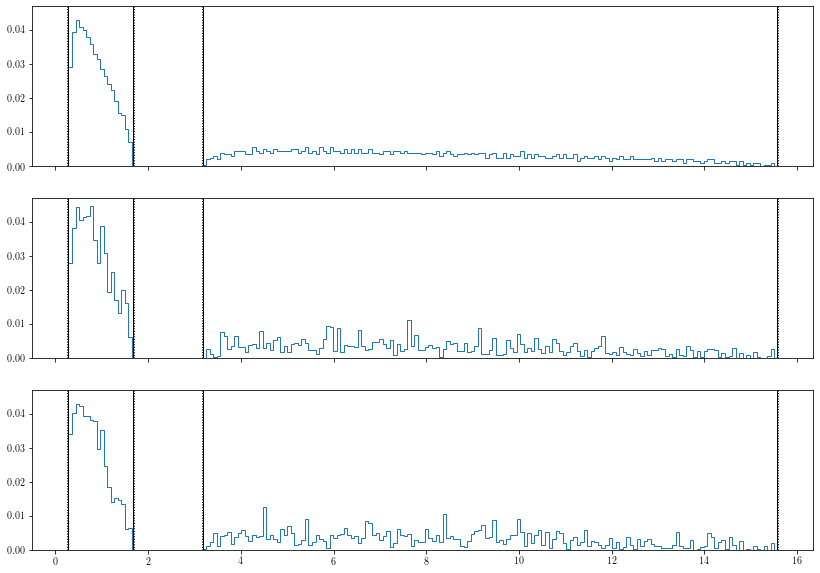

In [8]:
fig,axs = plt.subplots(3,1,figsize=(14,10),sharey=True,sharex=True)

for l in np.reshape(intervals_raw,-1):
    axs[0].axvline(l,color='k',lw=1)
    axs[1].axvline(l,color='k',lw=1)
    axs[2].axvline(l,color='k',lw=1)
    
for l in np.reshape(intervals,-1):
    axs[0].axvline(l,color='k',lw=1,ls=':')
    axs[1].axvline(l,color='k',lw=1,ls=':')
    axs[2].axvline(l,color='k',lw=1,ls=':')
    
axs[0].hist(lam,200,weights=np.ones(N)/N,histtype='step');
axs[1].hist(lam,200,weights=(Q.T@v)**2,histtype='step');

v0 = np.zeros(N)
v0[0] = 1
v0[-1] = 1
v0 /= np.linalg.norm(v0)

axs[2].hist(lam,200,weights=(Q.T@v0)**2,histtype='step');


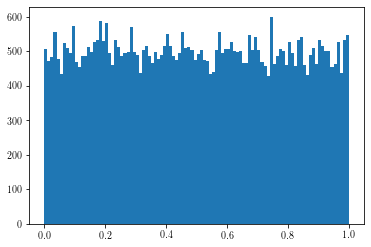

In [9]:
plt.hist(np.linspace(0,1,50000),100,weights=np.random.randn(50000)**2);

In [10]:
def mu_U(x,a,b): 
    with np.errstate(invalid='ignore'):
        return (8/(np.pi*(b-a)**2))*np.sqrt((x-a)*(b-x))
    
def mu_T(x,a,b): 
    with np.errstate(divide='ignore',invalid='ignore'):
        return 1/(np.pi)/(np.sqrt((x-a)*(b-x)))

In [11]:
N = 10000
d = 0.3;
σ = 8.0

intervals_raw = support_gen(N,d,σ)
intervals = intervals_raw + np.array([[-1,1],[-1,1]]) * 0.001

a = intervals[0,0]
b = intervals[1,1]

weights = [.5,.5]


In [12]:
mu = lambda x,a,b: mu_U(x,a,b)

def mu2(x):
    mu_x = np.zeros_like(x)
    l = len(weights)
    for i in range(l):
        mask = (intervals[i,0]<x)*(x<intervals[i,1])
        mu_x[mask] += weights[i]*mu(x[mask],intervals[i,0],intervals[i,1])
    return mu_x

In [13]:
k = 30
s = 2*k

αU = np.ones(s+1)*(a+b)/2
βU = np.ones(s+1)*(b-a)/4

αU_unscaled = np.zeros(s+1)
βU_unscaled = np.ones(s+1)/2

α2,β2 = get_op_recurrence(intervals,weights,αU_unscaled,βU_unscaled,s)

In [14]:
np.random.seed(0)

n_trials = 10

α  = np.zeros((n_trials,k))
β  = np.zeros((n_trials,k))
mU = np.zeros((n_trials,k+1))
m2 = np.zeros((n_trials,k+1))

for trial_idx in range(n_trials):
    
    clear_output(wait=True)
    print(trial_idx)
    
    A = mat_samp_full(N,d,σ)
    v = np.sign(np.random.rand(N)-.5) / np.sqrt(N)

    
    α[trial_idx],β[trial_idx] = lanczos(A,v,k)
    mU[trial_idx] = get_moments_from_lanczos(A,v,k,αU,βU,T=(α[trial_idx],β[trial_idx]))
    m2[trial_idx] = get_moments_from_lanczos(A,v,k,α2,β2,T=(α[trial_idx],β[trial_idx]))

9


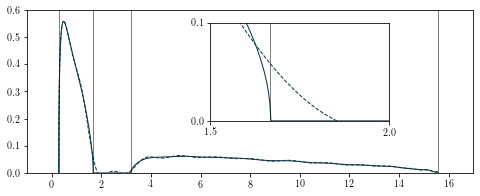

In [15]:
xx = np.linspace(a,b,5000)

fig,axs = plt.subplots(1,1,figsize=(8,3),sharey=True)
axs = [axs]

AQ_U = eval_poly(xx,np.mean(mU,axis=0),αU,βU)
AQ_2 = eval_poly(xx,np.mean(m2,axis=0),α2,β2)

axs[0].plot(xx,AQ_U*mu_U(xx,a,b),color='#073642',ls='--',lw=1)
axs[0].plot(xx,AQ_2*mu2(xx),color='#073642',lw=1)
    
for l in np.reshape(intervals_raw,-1):
    axs[0].axvline(l,color='k',lw=.5)

axs[0].set_ylim(0,.6)
axs[0].set_xlim(-1,17)

axins = inset_axes(axs[0], "100%","100%", loc='upper left', bbox_to_anchor=(0.4,.35,.4,.6), bbox_transform=axs[0].transAxes) # zoom = 6
axins.plot(xx,AQ_U*mu_U(xx,a,b),color='#073642',ls='--',lw=1)
axins.plot(xx,AQ_2*mu2(xx),color='#073642',lw=1)

for l in np.reshape(intervals_raw,-1):
    axins.axvline(l,color='k',lw=.5)

# sub region of the original image
x1, x2, y1, y2 = 1.5,2,0,.1
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticks([x1,x2])
axins.set_yticks([y1,y2])


plt.savefig('imgs/RM_split_AQ.pdf',bbox_inches='tight')

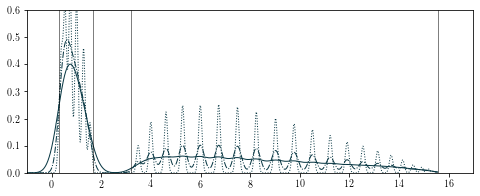

In [16]:
xx = np.linspace(-1,b,5000)

g_σ = lambda x,σ: 1/np.sqrt(2*np.pi*σ**2)*np.exp(-(x/σ)**2/2)

GQ0 = np.zeros_like(xx)
GQ1 = np.zeros_like(xx)
GQ2 = np.zeros_like(xx)

for trial_idx in range(n_trials):
    θ,ω = get_gq(k,α[trial_idx],β[trial_idx])
    for i in range(k):

        GQ0 += ω[i]*g_σ(xx-θ[i],2/k)
        GQ1 += ω[i]*g_σ(xx-θ[i],5/k)
        GQ2 += ω[i]*g_σ(xx-θ[i],10/k)
    
GQ0 /= n_trials
GQ1 /= n_trials
GQ2 /= n_trials


fig,axs = plt.subplots(1,1,figsize=(8,3),sharey=True)
axs = [axs]

axs[0].plot(xx,GQ0,color='#073642',ls=':',lw=1)
axs[0].plot(xx,GQ1,color='#073642',ls='-.',lw=1)
axs[0].plot(xx,GQ2,color='#073642',ls='-',lw=1)
    
for l in np.reshape(intervals_raw,-1):
    axs[0].axvline(l,color='k',lw=.5)

axs[0].set_ylim(0,.6)
axs[0].set_xlim(-1,17)

plt.savefig('imgs/RM_split_GQ.pdf',bbox_inches='tight')